In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchmetrics import Metric
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.datasets import CocoDetection
from torchmetrics import Accuracy
import copy
from PIL import Image
import cv2
import albumentations as A 
from collections import defaultdict, deque
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline
print(torch.__version__)
print(torchvision.__version__)
from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2
import wandb
import matplotlib.patches as patches



2.2.1+cu121
0.17.1+cu121


# Hyper paramaters

In [2]:
# Hyperparameters
batch_size = 8
num_epochs= 200
lr = 0.0001
squared_gradient = 0.999
momentum = 0.9
image_size = [600, 600]
wandb_on = True
device_cuda = "GPU" # GPU or CPU
model_name = "god" # hurtig or god
num_workers = 0

# Log the run to Wandb
if wandb_on:
    wandb.login()

# Set device
if device_cuda == "GPU":
    print("Using GPU")
    device = torch.device("cuda") # use GPU to train
elif device_cuda == "CPU":
    print("Using CPU")
    device = "cpu"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tobped. Use `wandb login --relogin` to force relogin


Using GPU


# Transforms

In [3]:
# Define transforms for the dataset
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(image_size[0], image_size[1]), 
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(image_size[0], image_size[1]), 
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

# Data Import

In [4]:

# Custom dataset class
class PotholeDetectionClass(datasets.VisionDataset):
    def __init__(self, root, stage='/train', transform=None, target_transform=None, transforms=None, batch_size = batch_size):
        super().__init__(root, transforms, transform, target_transform)
        self.stage = stage #train, valid, test
        self.coco = COCO(root + stage + "/_annotations.coco.json") # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
        self.batch_size = batch_size

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        path = "/" + path
        image = cv2.imread(self.root + self.stage + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]

        transformed = self.transforms(image=image, bboxes=boxes)
        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        image = torch.tensor(image, dtype=torch.float32).div(255)

           # Convert target dictionary into tensors
        targ = {key: torch.tensor(val) for key, val in targ.items()}
        return image, targ # scale images
    
    def __len__(self):
        return len(self.ids)
    
# Set the path to the dataset
dataset_path = "/Pothole_coco"
dataset_path = os.getcwd() + dataset_path
# Load the annotations
coco = COCO(dataset_path + "/train" + "/_annotations.coco.json")
categories = coco.cats
n_classes = len(categories.keys())
# Load the dataset
train_dataset = PotholeDetectionClass(root=dataset_path, transforms=get_transforms(True))
test_dataset = PotholeDetectionClass(root=dataset_path, stage='/test', transforms=get_transforms(False))
val_dataset = PotholeDetectionClass(root=dataset_path, stage= "/valid", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# DataLoader

In [5]:
def custom_collate(batch):
    return tuple(zip(*batch))

# Additional

In [6]:
# Mothod to plot the image with the bounding boxes
def plot_image(img_tensor, annotation,phase='train'):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu()

    ax.imshow(img.permute(1, 2, 0))
    for idx,box in enumerate(annotation["boxes"]):

        xmin, ymin, xmax, ymax = box
        color=['r','g','b','r']
        classes=['no mask','Masked','Improper masking','No-mask']
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor=color[annotation['labels'][idx]],facecolor='none')
        ax.text(xmin, ymin, classes[annotation['labels'][idx]],color='black',bbox=dict(facecolor=color[annotation['labels'][idx]], alpha=0.1))
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()


def accuracyMetric(preds,annotations):
    non_accurate=0
    accurate=0
    def csm(A,B,corr):
        if corr:
            B=B-B.mean(axis=1)[:,np.newaxis]
            A=A-A.mean(axis=1)[:,np.newaxis]
        num=np.dot(A,B.T)
        p1=np.sqrt(np.sum(A**2,axis=1))[:,np.newaxis]
        p2=np.sqrt(np.sum(B**2,axis=1))[np.newaxis,:]
        return 1-(num/(p1*p2))
    inds=torch.where((preds['scores'])>0.91)
    distMatrix=csm(np.array(preds['boxes'][inds].cpu()),np.array(annotations['boxes'].cpu()),True)

    for i in range (distMatrix.shape[0]):
        cla=np.argmin(distMatrix[i,:])

        if preds['labels'][i]%3==annotations['labels'][cla]:
            accurate+=1
        else:
            non_accurate+=1
    allSamp=np.max(((accurate+non_accurate),len(annotations['labels'])))
    return (accurate/allSamp)

# Neural Network

In [7]:
# Define the neural network
class NN(pl.LightningModule):
    def __init__(self, image_plot_id = 0):
        super().__init__()
        self.model = self.configure_model()
        self.optimizer = self.configure_optimizers()
        self.train_loader = self.train_dataloader()
        self.thresh  =  0.5
        self.test_loader = self.test_dataloader()
        self.val_loader = self.val_dataloader()
        self.loss = nn.BCEWithLogitsLoss()
        self.losses_dict = []
        self.save_hyperparameters()
        self.image_plot_id = image_plot_id

    def forward(self, x, annotations=None, phase='train'):
        if phase=='train':
            out=self.model(x,annotations)
        else:
            self.model.eval()
            out=self.model(x[0])
        # no activation and no softmax at the end
        return out

    def training_step(self, batch, batch_idx):
        imgs, annotation_labels = batch
        self.optimizer.zero_grad()
        loss_dict = self(imgs, annotation_labels)
        losses = sum(loss for loss in loss_dict.values())

        self.optimizer.step()
        #if wandb_on:
            #wandb.log({"train/loss": losses}, on_epoch=True)
        self.log('train/loss', losses, on_epoch=True)
        return losses

    def test_step(self,batch,batch_idx):
        imgs, annotations = batch
        annotations = [{k: v for k, v in t.items()} for t in annotations]
        preds = self(list([imgs]),phase='test')
        classes = [i[1]['name'] for i in categories.items()]
        img, _ = test_dataset[self.image_plot_id]
        self.image_plot_id = self.image_plot_id+1
        img_int = torch.tensor(img*255, dtype=torch.uint8)
        with torch.no_grad():
            prediction = self.model([img.to(device)])
            pred = prediction[0]
            fig = plt.figure(figsize=(14, 10))
        plt.imshow(draw_bounding_boxes(img_int,
            pred['boxes'][pred['scores'] > 0.6],
            [classes[i] for i in pred['labels'][pred['scores'] > 0.6].tolist()], width=4
        ).permute(1, 2, 0))
        
        self.log('test/accuracy',(accuracyMetric(preds[0], annotations[0])),on_epoch=True)

        #self.log('accuracy',(accuracyMetric(preds[0], annotations[0])),on_epoch=True)
        #print((accuracyMetric(preds[0], annotations[0])))

    def validation_step(self, batch, batch_idx):
        imgs, annotations = batch
        annotations = [{k: v for k, v in t.items()} for t in annotations]
        preds = self(list([imgs]),phase='val')
        self.log('validate/accuracy',(accuracyMetric(preds[0], annotations[0])),on_epoch=True)
        #print(accuracyMetric(preds[0], annotations[0]))
        return accuracyMetric(preds[0], annotations[0])

    def configure_model(self):
        if model_name == "hurtig":
            model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)    # hurtig
        elif model_name == "god":
            model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)                   # god

        model = model.to(device)
        return model

    def configure_optimizers(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.Adam(params, lr=lr, weight_decay=1e-4) # to change adam use F12 and changes betas
        return self.optimizer

    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=custom_collate)
        return train_loader

    def test_dataloader(self):
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)
        return test_loader
    
    def val_dataloader(self): # Virker ikke endnu (skal åbenbart være val_dataloader, men det virker heller ikke)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)
        return val_loader


# Training

In [8]:
lightning_module = NN()
# Initialize a Lightning Trainer
if wandb_on:

    wandb_logger = WandbLogger(project="bachelor0386",job_type='train') # for test brug "test1234544-org" og for train brug "bachelor0386"
    wandb_logger.experiment.name = "200 epochs god b:8"
    wandb_logger.experiment.config["batch_size"] = batch_size
    wandb_logger.experiment.config["num_epochs"] = num_epochs
    wandb_logger.experiment.config["lr"] = lr
    #wandb_logger = WandbLogger(project='Bachelor', job_type='train')
    wandb_logger.watch(lightning_module.model, log="all")
    trainer = pl.Trainer(max_epochs=num_epochs,logger=wandb_logger)  # You can adjust the Trainer options
else:
    trainer = pl.Trainer(max_epochs=num_epochs)
# Start training

trainer.fit(lightning_module)



C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\tobia\AppData\Local\Temp\ipykernel_18468\1035951359.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).div(255)
C:\Users\tobia\AppData\Local\Temp\ipykernel_18468\1035951359.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ = {key

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.04it/s]

C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 117:   0%|          | 0/59 [00:00<?, ?it/s, v_num=b5cp]         

# Load Checkpoint

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\tobia\AppData\Local\Temp\ipykernel_24336\1035951359.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).div(255)
C:\Users\tobia\AppData\Local\Temp\ipykernel_24336\1035951359.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ = {key: torch.tensor(val) for key, val in targ.items()}


Testing DataLoader 0:  11%|█         | 1/9 [00:00<00:03,  2.03it/s]

C:\Users\tobia\AppData\Local\Temp\ipykernel_24336\893574865.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8)


Testing DataLoader 0:  44%|████▍     | 4/9 [00:01<00:01,  2.53it/s]

C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


Testing DataLoader 0: 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.4444444477558136     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.4444444477558136}]

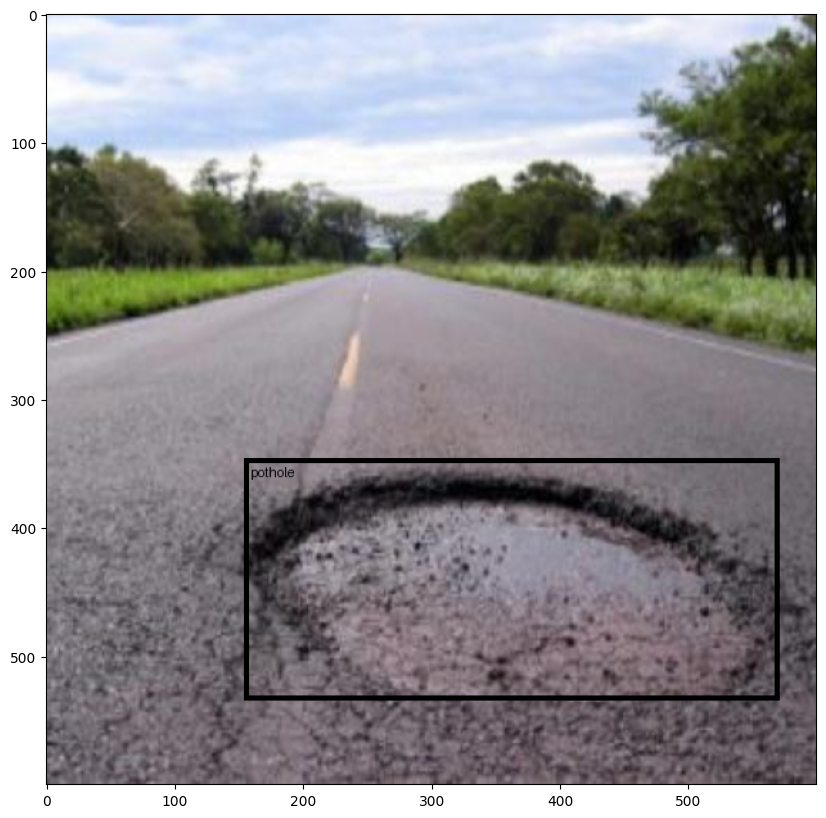

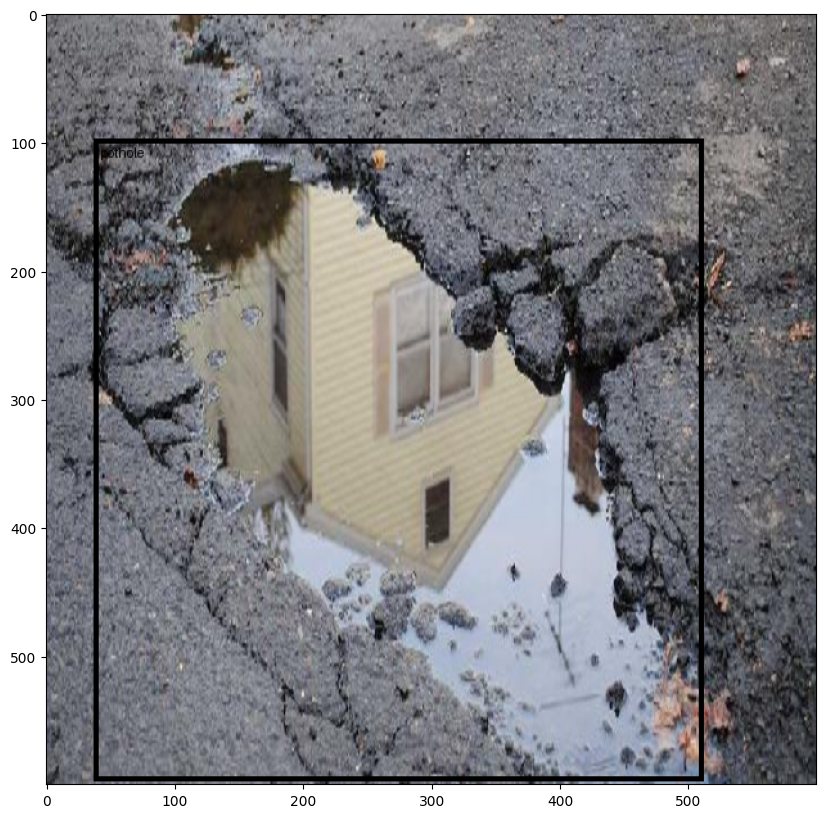

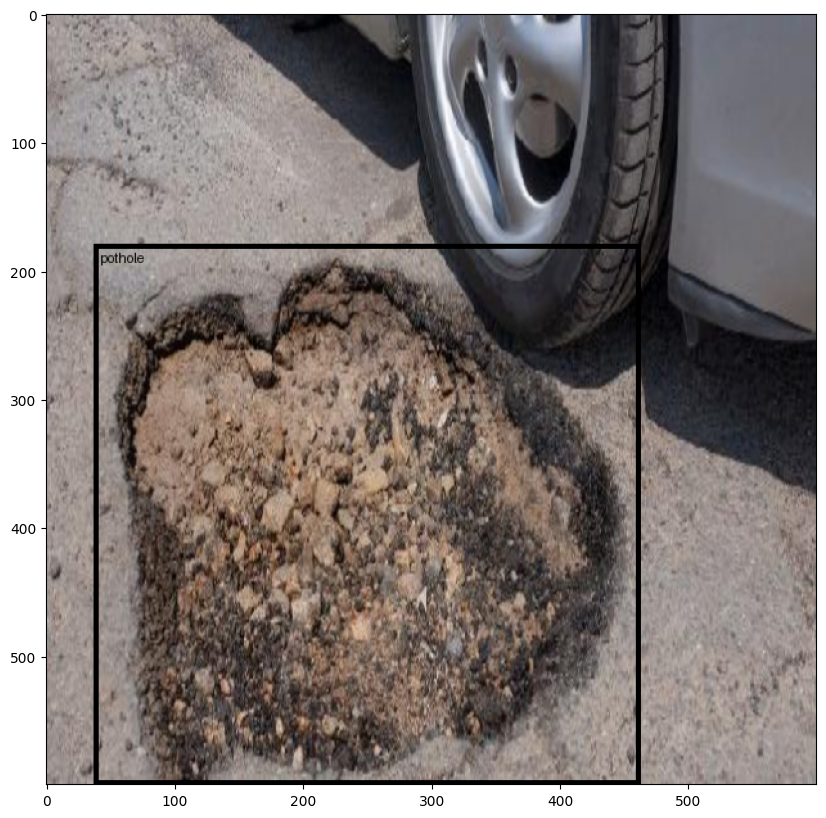

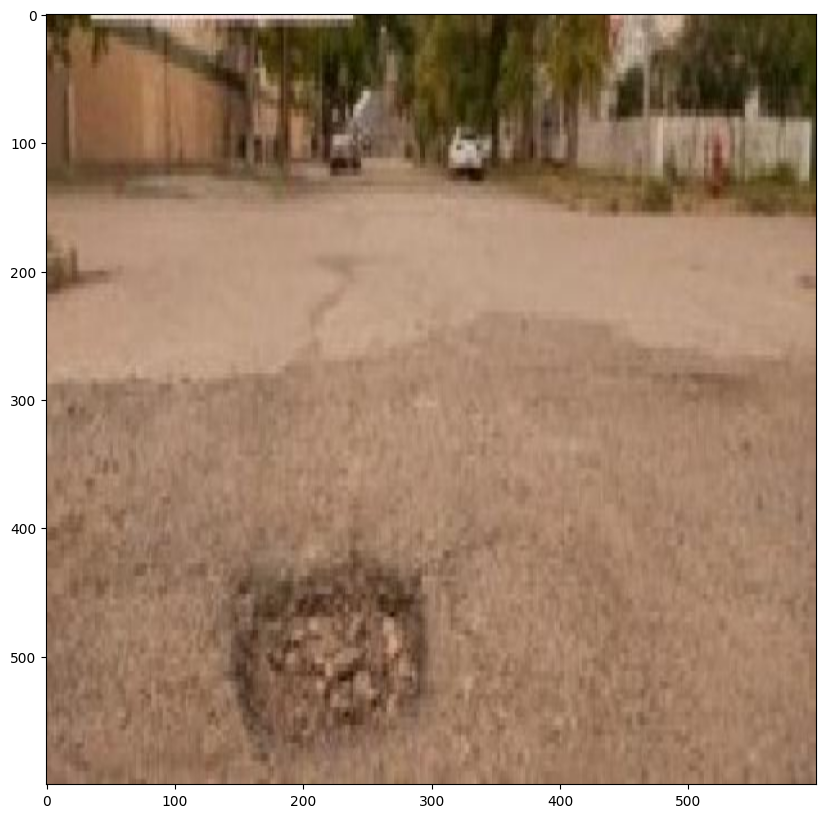

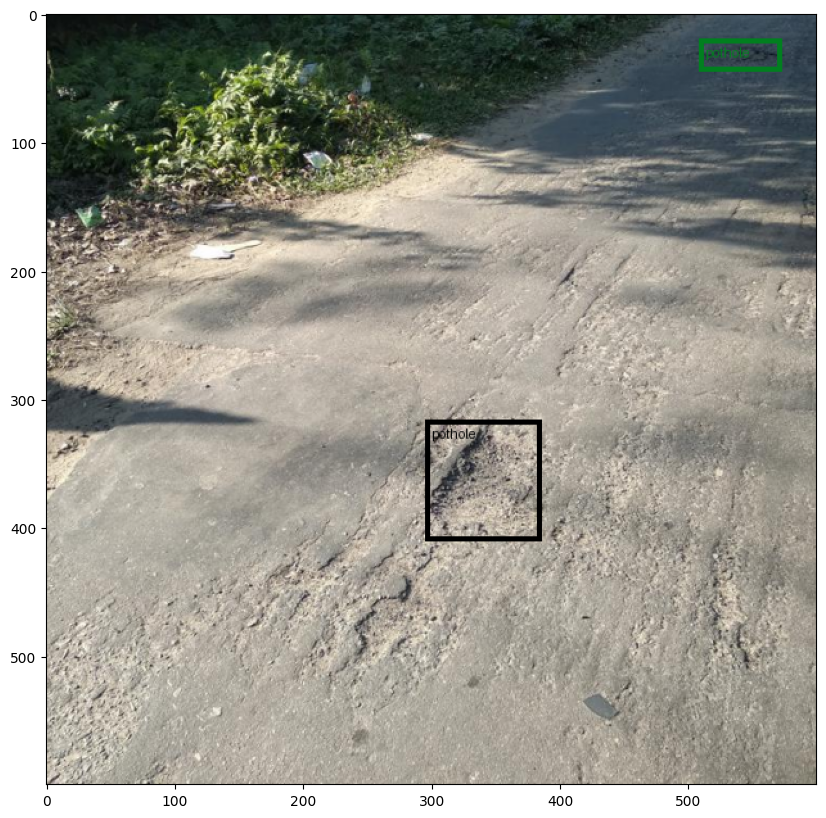

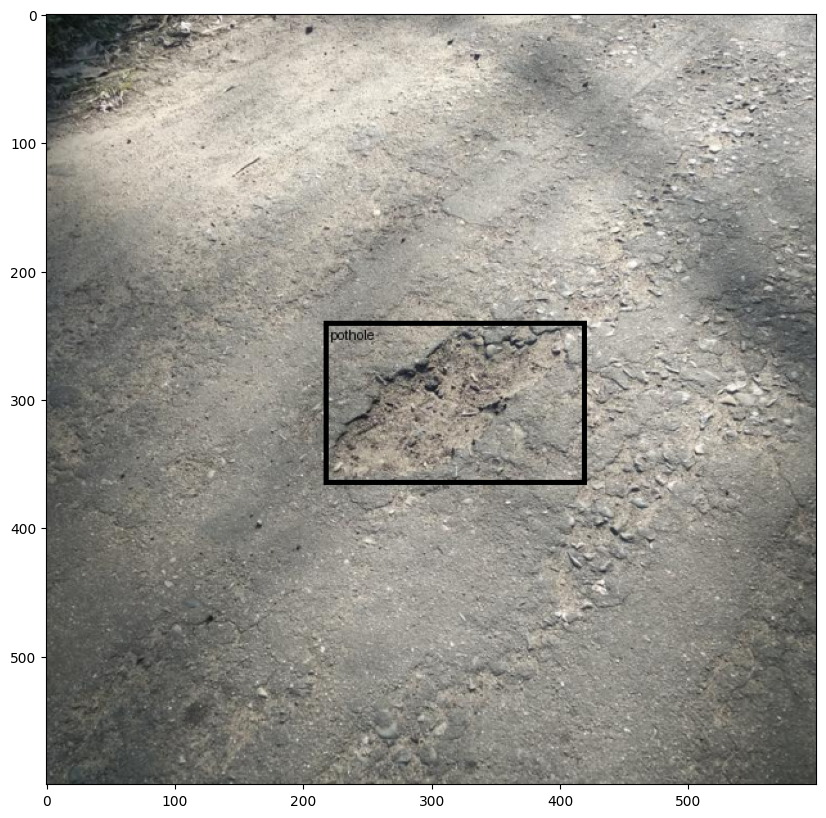

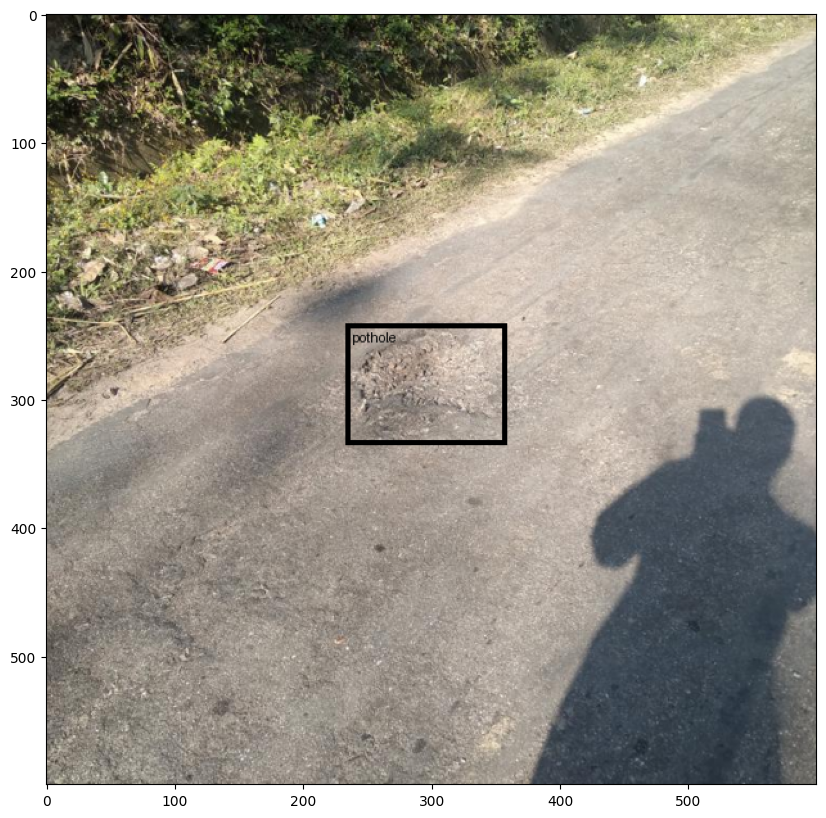

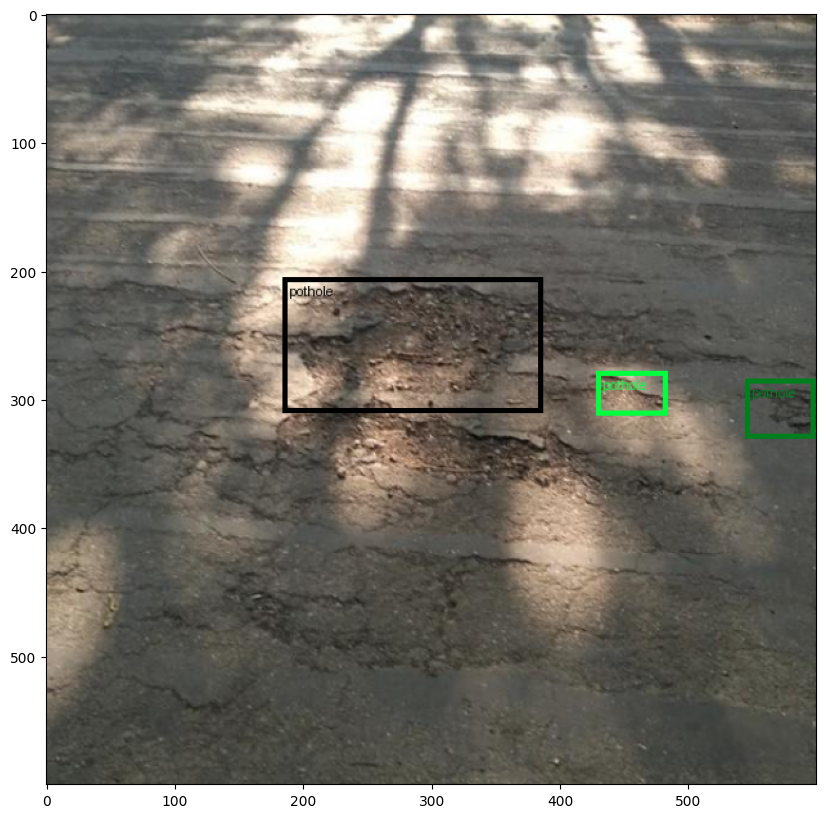

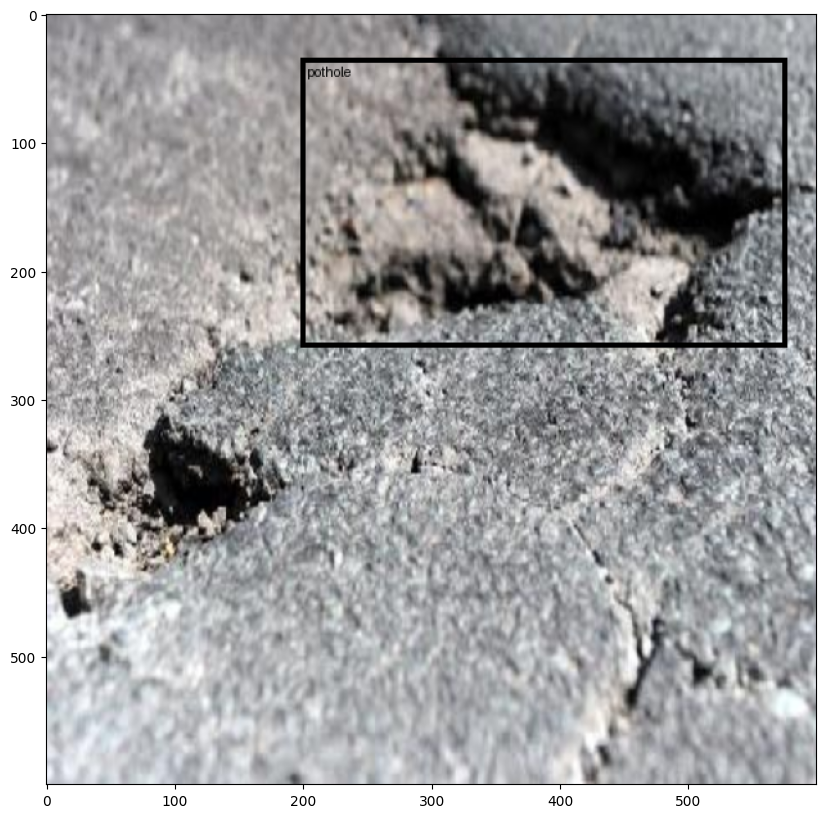

In [ ]:
#ckpt_path = "lightning_logs/version_3/checkpoints/epoch=0-step=59.ckpt"
#ckpt_path = "bachelor0386/wc3tnlim/checkpoints/epoch=299-step=17700.ckpt"

#NN.load_from_checkpoint(ckpt_path)
#trainer = pl.Trainer(max_epochs=10)
#trainer.fit(lightning_module)
trainer.test(lightning_module)

# Testing

In [ ]:
#trainer.test(lightning_module)


# Validate

In [ ]:
trainer.validate(lightning_module)
if wandb_on:
    wandb.finish()


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0:   0%|          | 0/17 [00:00<?, ?it/s]

C:\Users\tobia\AppData\Local\Temp\ipykernel_24336\1035951359.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).div(255)
C:\Users\tobia\AppData\Local\Temp\ipykernel_24336\1035951359.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ = {key: torch.tensor(val) for key, val in targ.items()}


Validation DataLoader 0: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.5833333134651184     │
└───────────────────────────┴───────────────────────────┘